# PapyrusNU Hieroglyph Detection - Model Predictions Visualization

This notebook creates comprehensive visualizations of your trained model's predictions on the test set.

## What you'll see:
1. **Side-by-side comparisons**: Ground truth vs predictions
2. **Confidence score analysis**: How confident is the model?
3. **Class-specific performance**: Which hieroglyphs work best?
4. **Detection overlays**: Visual prediction results
5. **Performance metrics**: Detailed analysis


In [1]:
# Install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-s5rpcs0g
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-s5rpcs0g
  Resolved https://github.com/facebookresearch/fvcore.git to commit 3b2d62f06b22ef743ac394e568e1e87ae12b30a8
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-nt9ac7ag
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-nt9ac7ag
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65635 sha256=2074d8cd889c016a29cdac7a9d4d4d4b535c8cd8df5857bd8138dbda01271c9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-jr10q841/wheels/cb/7b/f1/170e6ac46b414a6afef30f04f353ef29c6d7b20051358b781a


'2.8.0+cu128'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/detectron2_repo
  Preparing metadata (setup.py) ... done
  Using cached pycocotools-2.0.10-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
  Using cached fvcore-0.1.5.post20221221-py3-none-any.whl
Using cached pycocotools-2.0.10-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (477 kB)
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
  Attempting uninstall: fvcore
    Found existing installation: fvcore 0.1.6
    Uninstalling fvcore-0.1.6:
      Successfully uninstalled fvcore-0.1.6
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6
    Uninstalling detectron2-0.6:
      Successfully uninstalled detectron2-0.6
  Running setup.py develop for detectron2


In [3]:
# Import libraries
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns
import cv2
import torch
from PIL import Image
from collections import Counter, defaultdict
import pandas as pd
import glob

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up paths
PROJECT_ROOT = '/content/drive/My Drive/PapyrusNU_Detectron'
DATA_DIR = f'{PROJECT_ROOT}/data'
MODELS_DIR = f'{PROJECT_ROOT}/models'
SCRIPTS_DIR = f'{PROJECT_ROOT}/scripts'

sys.path.append(SCRIPTS_DIR)

print(' Model Prediction Visualization Setup Complete!')
print(f'Project: {PROJECT_ROOT}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Model Prediction Visualization Setup Complete!
Project: /content/drive/My Drive/PapyrusNU_Detectron


In [4]:
import sys
import os

print("Current system path:")
for path in sys.path:
    print(path)

print("\nContents of scripts directory:")
scripts_dir = '/content/drive/My Drive/PapyrusNU_Detectron/scripts'
if os.path.exists(scripts_dir):
    for item in os.listdir(scripts_dir):
        print(item)
else:
    print(f"Directory not found: {scripts_dir}")

Current system path:
/content
/env/python
/usr/lib/python311.zip
/usr/lib/python3.11
/usr/lib/python3.11/lib-dynload

/usr/local/lib/python3.11/dist-packages
/content/detectron2_repo
/usr/lib/python3/dist-packages
/usr/local/lib/python3.11/dist-packages/IPython/extensions
/root/.ipython
/tmp/tmpmhydjnw9
/content/drive/My Drive/PapyrusNU_Detectron/scripts

Contents of scripts directory:
visualization.py
evaluation.py
dataset_utils.py
__pycache__


In [5]:
# Import Detectron2 components
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

# Import custom utilities
from dataset_utils import create_detectron2_dataset_dict

print(f' Detectron2 version: {detectron2.__version__}')
print(' Custom utilities loaded')

 Detectron2 version: 0.6
 Custom utilities loaded


## Load Model and Data

In [6]:
# Load the trained model
model_dirs = glob.glob(f'{MODELS_DIR}/hieroglyph_model_*')
latest_model_dir = sorted(model_dirs)[-1]

print(f'📁 Loading model: {os.path.basename(latest_model_dir)}')

# Load model info
with open(f'{latest_model_dir}/model_info.json', 'r') as f:
    model_info = json.load(f)

# Load test data
with open(f'{DATA_DIR}/annotations/test_annotations.json', 'r') as f:
    test_data = json.load(f)

test_dataset_dicts = create_detectron2_dataset_dict(test_data, f'{DATA_DIR}/images')

print(f' Model Info:')
print(f'   Classes: {model_info["num_classes"]}')
print(f'   Test images: {len(test_dataset_dicts)}')
print(f'   Test annotations: {len(test_data["annotations"])}')

📁 Loading model: hieroglyph_model_20250807_190054
 Model Info:
   Classes: 177
   Test images: 1
   Test annotations: 316


In [7]:
# Set up model for CPU prediction
cfg = get_cfg()
cfg.merge_from_file(f'{latest_model_dir}/config.yaml')
cfg.MODEL.WEIGHTS = f'{latest_model_dir}/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = model_info['detection_threshold']
cfg.MODEL.DEVICE = 'cpu'  # Force CPU usage

print(' Loading model for prediction (CPU mode)...')
predictor = DefaultPredictor(cfg)
print(' Model loaded successfully!')

 Loading model for prediction (CPU mode)...
 Model loaded successfully!


## Generate Predictions on Test Set

In [8]:
# Generate predictions for all test images
all_predictions = []
all_ground_truth = []

print('🔍 Generating predictions on test set...')

for i, dataset_dict in enumerate(test_dataset_dicts):
    print(f'Processing image {i+1}/{len(test_dataset_dicts)}: {os.path.basename(dataset_dict["file_name"])}')

    # Load image
    img = cv2.imread(dataset_dict['file_name'])

    # Make prediction
    outputs = predictor(img)
    instances = outputs['instances'].to('cpu')

    # Store predictions
    image_predictions = {
        'image_id': dataset_dict['image_id'],
        'file_name': dataset_dict['file_name'],
        'image_shape': img.shape,
        'predictions': {
            'boxes': instances.pred_boxes.tensor.numpy() if len(instances) > 0 else np.array([]),
            'scores': instances.scores.numpy() if len(instances) > 0 else np.array([]),
            'classes': instances.pred_classes.numpy() if len(instances) > 0 else np.array([]),
            'masks': instances.pred_masks.numpy() if len(instances) > 0 and hasattr(instances, 'pred_masks') else None
        },
        'ground_truth': dataset_dict['annotations']
    }

    all_predictions.append(image_predictions)

    print(f'   Detections: {len(instances)}, Ground truth: {len(dataset_dict["annotations"])}')

print(f'\n Prediction generation complete!')
print(f'   Total predictions across all images: {sum(len(pred["predictions"]["scores"]) for pred in all_predictions)}')
print(f'   Total ground truth annotations: {sum(len(pred["ground_truth"]) for pred in all_predictions)}')

🔍 Generating predictions on test set...
Processing image 1/1: 145_upscaled_bright.jpg


/usr/local/lib/python3.11/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


   Detections: 27, Ground truth: 316

 Prediction generation complete!
   Total predictions across all images: 27
   Total ground truth annotations: 316


## Visualization 1: Side-by-Side Comparison

In [9]:
# Create side-by-side visualizations for each test image
def draw_annotations_on_image(img, annotations, category_names, title_prefix="", color='red'):
    """Draw bounding boxes for annotations"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    for ann in annotations:
        if 'bbox' in ann:
            # Ground truth format: [x, y, width, height]
            x, y, w, h = ann['bbox']
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            # Add class label
            if 'category_id' in ann and ann['category_id'] < len(category_names):
                class_name = category_names[ann['category_id']]
                ax.text(x, y-5, class_name, color=color, fontsize=8, weight='bold')

    ax.set_title(f'{title_prefix} ({len(annotations)} annotations)')
    ax.axis('off')
    return fig, ax

def draw_predictions_on_image(img, predictions, category_names, title_prefix="", color='blue'):
    """Draw bounding boxes for predictions"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    boxes = predictions['boxes']
    scores = predictions['scores']
    classes = predictions['classes']

    for i in range(len(boxes)):
        # Prediction format: [x1, y1, x2, y2]
        x1, y1, x2, y2 = boxes[i]
        w, h = x2 - x1, y2 - y1

        # Color based on confidence
        confidence = scores[i]
        alpha = 0.3 + 0.7 * confidence  # Higher confidence = more opaque

        rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color,
                        facecolor='none', alpha=alpha)
        ax.add_patch(rect)

        # Add class label and confidence
        class_idx = int(classes[i])
        if class_idx < len(category_names):
            class_name = category_names[class_idx]
            label = f'{class_name} ({confidence:.2f})'
            ax.text(x1, y1-5, label, color=color, fontsize=8, weight='bold')

    ax.set_title(f'{title_prefix} ({len(boxes)} detections)')
    ax.axis('off')
    return fig, ax

print(' Creating side-by-side visualizations...')

# Create visualizations for each test image
for i, pred_data in enumerate(all_predictions):
    img = cv2.imread(pred_data['file_name'])
    image_name = os.path.basename(pred_data['file_name'])

    # Create side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

    # Ground Truth (Left)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax1.imshow(img_rgb)

    # Draw ground truth annotations
    for ann in pred_data['ground_truth']:
        x, y, w, h = ann['bbox']
        rect = Rectangle((x, y), w, h, linewidth=3, edgecolor='red', facecolor='none')
        ax1.add_patch(rect)

        # Add ground truth label
        if ann['category_id'] < len(model_info['category_names']):
            class_name = model_info['category_names'][ann['category_id']]
            ax1.text(x, y-10, class_name, color='red', fontsize=10, weight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    ax1.set_title(f'Ground Truth: {image_name}\n{len(pred_data["ground_truth"])} annotations', fontsize=14)
    ax1.axis('off')

    # Predictions (Right)
    ax2.imshow(img_rgb)

    # Draw predictions
    boxes = pred_data['predictions']['boxes']
    scores = pred_data['predictions']['scores']
    classes = pred_data['predictions']['classes']

    for j in range(len(boxes)):
        x1, y1, x2, y2 = boxes[j]
        w, h = x2 - x1, y2 - y1
        confidence = scores[j]

        # Color based on confidence: green for high, yellow for medium, orange for low
        if confidence >= 0.8:
            color = 'green'
        elif confidence >= 0.6:
            color = 'blue'
        else:
            color = 'orange'

        rect = Rectangle((x1, y1), w, h, linewidth=3, edgecolor=color, facecolor='none')
        ax2.add_patch(rect)

        # Add prediction label
        class_idx = int(classes[j])
        if class_idx < len(model_info['category_names']):
            class_name = model_info['category_names'][class_idx]
            label = f'{class_name}\n{confidence:.3f}'
            ax2.text(x1, y1-15, label, color=color, fontsize=10, weight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # Add confidence color legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='green', alpha=0.3, label='High confidence (≥0.8)'),
        plt.Rectangle((0,0),1,1, facecolor='blue', alpha=0.3, label='Medium confidence (0.6-0.8)'),
        plt.Rectangle((0,0),1,1, facecolor='orange', alpha=0.3, label='Low confidence (<0.6)')
    ]
    ax2.legend(handles=legend_elements, loc='upper right')

    ax2.set_title(f'Model Predictions: {image_name}\n{len(boxes)} detections', fontsize=14)
    ax2.axis('off')

    plt.suptitle(f'Hieroglyph Detection Comparison - Image {i+1}', fontsize=16, y=0.95)
    plt.tight_layout()

    # Save the visualization
    output_path = f'{latest_model_dir}/prediction_comparison_{i+1}.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f' Saved: {output_path}')

print(' Side-by-side visualizations complete!')

Output hidden; open in https://colab.research.google.com to view.

## Visualization 2: Confidence Score Analysis

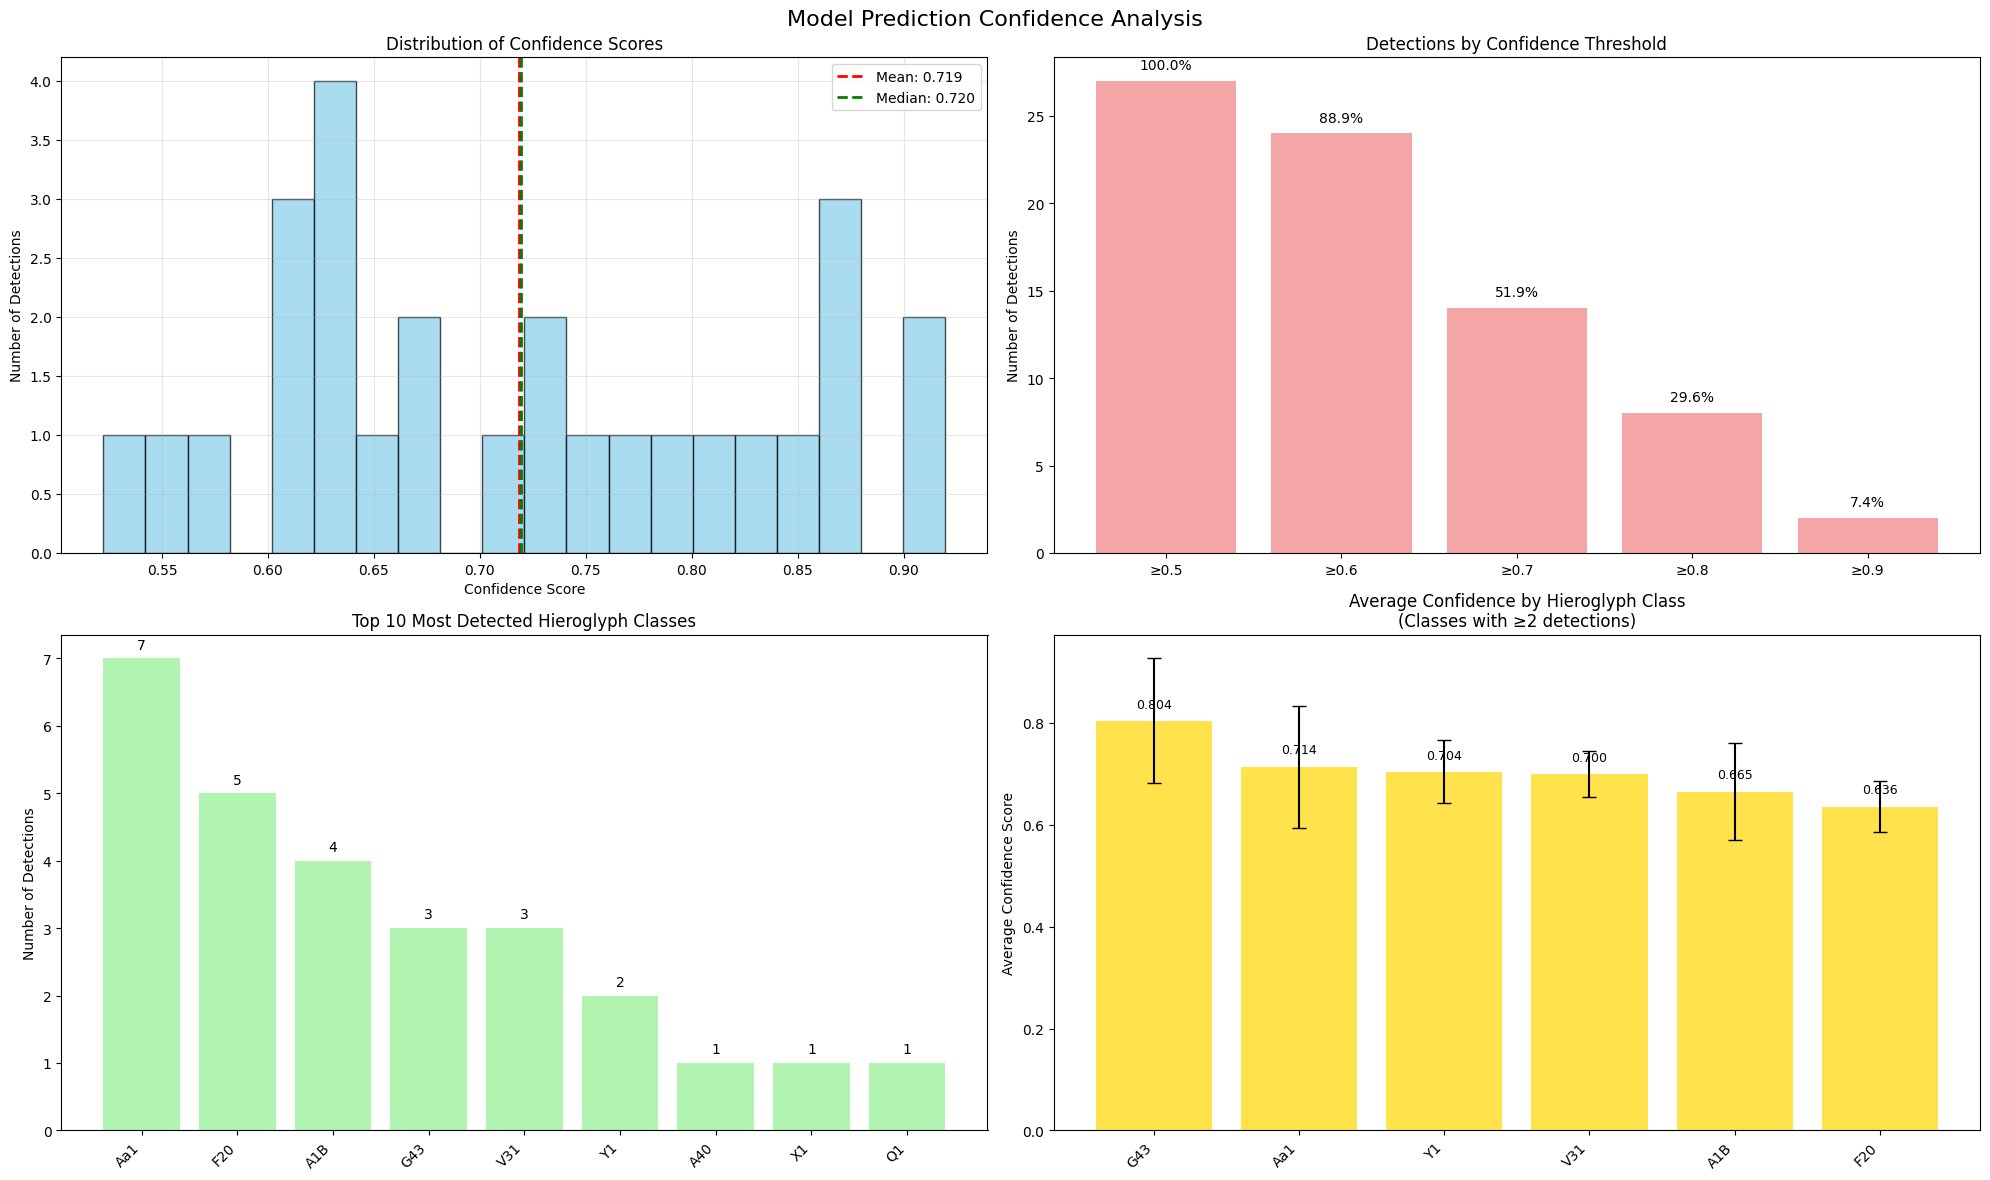

 Confidence analysis saved: /content/drive/My Drive/PapyrusNU_Detectron/models/hieroglyph_model_20250807_190054/confidence_analysis.png

 CONFIDENCE SCORE SUMMARY:
   Total detections: 27
   Mean confidence: 0.719
   Median confidence: 0.720
   Standard deviation: 0.115
   Min confidence: 0.522
   Max confidence: 0.920
   High confidence detections (≥0.8): 8 (29.6%)


In [10]:
# Analyze confidence scores across all predictions
all_scores = []
all_classes = []
class_scores = defaultdict(list)

for pred_data in all_predictions:
    scores = pred_data['predictions']['scores']
    classes = pred_data['predictions']['classes']

    all_scores.extend(scores)
    all_classes.extend(classes)

    for score, class_idx in zip(scores, classes):
        class_name = model_info['category_names'][int(class_idx)]
        class_scores[class_name].append(score)

if all_scores:
    # Create confidence analysis plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

    # 1. Confidence distribution histogram
    ax1.hist(all_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(np.mean(all_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_scores):.3f}')
    ax1.axvline(np.median(all_scores), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(all_scores):.3f}')
    ax1.set_xlabel('Confidence Score')
    ax1.set_ylabel('Number of Detections')
    ax1.set_title('Distribution of Confidence Scores')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Confidence by threshold
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    counts = [sum(1 for s in all_scores if s >= thresh) for thresh in thresholds]
    percentages = [c/len(all_scores)*100 for c in counts]

    bars = ax2.bar([f'≥{t}' for t in thresholds], counts, alpha=0.7, color='lightcoral')
    ax2.set_ylabel('Number of Detections')
    ax2.set_title('Detections by Confidence Threshold')

    # Add percentage labels on bars
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{pct:.1f}%', ha='center', va='bottom')

    # 3. Top detected classes with confidence
    class_counts = Counter(model_info['category_names'][int(c)] for c in all_classes)
    top_classes = class_counts.most_common(10)

    if top_classes:
        class_names = [item[0] for item in top_classes]
        class_detection_counts = [item[1] for item in top_classes]

        bars = ax3.bar(range(len(class_names)), class_detection_counts, alpha=0.7, color='lightgreen')
        ax3.set_xticks(range(len(class_names)))
        ax3.set_xticklabels(class_names, rotation=45, ha='right')
        ax3.set_ylabel('Number of Detections')
        ax3.set_title('Top 10 Most Detected Hieroglyph Classes')

        # Add count labels on bars
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', va='bottom')

    # 4. Average confidence by class (for classes with multiple detections)
    classes_with_multiple = {k: v for k, v in class_scores.items() if len(v) >= 2}
    if classes_with_multiple:
        sorted_classes = sorted(classes_with_multiple.items(),
                              key=lambda x: np.mean(x[1]), reverse=True)[:10]

        class_names = [item[0] for item in sorted_classes]
        avg_confidences = [np.mean(item[1]) for item in sorted_classes]
        std_confidences = [np.std(item[1]) for item in sorted_classes]

        bars = ax4.bar(range(len(class_names)), avg_confidences,
                      yerr=std_confidences, alpha=0.7, color='gold', capsize=5)
        ax4.set_xticks(range(len(class_names)))
        ax4.set_xticklabels(class_names, rotation=45, ha='right')
        ax4.set_ylabel('Average Confidence Score')
        ax4.set_title('Average Confidence by Hieroglyph Class\n(Classes with ≥2 detections)')

        # Add confidence labels
        for bar, conf in zip(bars, avg_confidences):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{conf:.3f}', ha='center', va='bottom', fontsize=9)

    plt.suptitle('Model Prediction Confidence Analysis', fontsize=16, y=0.98)
    plt.tight_layout()

    # Save the analysis
    confidence_analysis_path = f'{latest_model_dir}/confidence_analysis.png'
    plt.savefig(confidence_analysis_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f' Confidence analysis saved: {confidence_analysis_path}')

    # Print summary statistics
    print('\n CONFIDENCE SCORE SUMMARY:')
    print(f'   Total detections: {len(all_scores)}')
    print(f'   Mean confidence: {np.mean(all_scores):.3f}')
    print(f'   Median confidence: {np.median(all_scores):.3f}')
    print(f'   Standard deviation: {np.std(all_scores):.3f}')
    print(f'   Min confidence: {np.min(all_scores):.3f}')
    print(f'   Max confidence: {np.max(all_scores):.3f}')
    print(f'   High confidence detections (≥0.8): {sum(1 for s in all_scores if s >= 0.8)} ({sum(1 for s in all_scores if s >= 0.8)/len(all_scores)*100:.1f}%)')

else:
    print(' No predictions found to analyze')

## Visualization 3: Detection Summary Report

In [11]:
# Create a comprehensive summary report
print(' COMPREHENSIVE DETECTION SUMMARY REPORT')
print('='*60)

total_predictions = sum(len(pred['predictions']['scores']) for pred in all_predictions)
total_ground_truth = sum(len(pred['ground_truth']) for pred in all_predictions)
unique_predicted_classes = len(set(all_classes))
unique_gt_classes = len(set(ann['category_id'] for pred in all_predictions for ann in pred['ground_truth']))

print(f'\n OVERALL PERFORMANCE:')
print(f'   Test Images: {len(all_predictions)}')
print(f'   Total Predictions: {total_predictions}')
print(f'   Total Ground Truth: {total_ground_truth}')
print(f'   Detection Rate: {total_predictions/total_ground_truth:.2%}')
print(f'   Unique Classes Predicted: {unique_predicted_classes}')
print(f'   Unique Classes in GT: {unique_gt_classes}')
print(f'   Class Coverage: {unique_predicted_classes/unique_gt_classes:.2%}')

if all_scores:
    print(f'\n CONFIDENCE METRICS:')
    print(f'   Mean Confidence: {np.mean(all_scores):.3f}')
    print(f'   High Confidence (≥0.8): {sum(1 for s in all_scores if s >= 0.8)} detections ({sum(1 for s in all_scores if s >= 0.8)/len(all_scores)*100:.1f}%)')
    print(f'   Medium Confidence (0.6-0.8): {sum(1 for s in all_scores if 0.6 <= s < 0.8)} detections')
    print(f'   Low Confidence (<0.6): {sum(1 for s in all_scores if s < 0.6)} detections')

print(f'\n🏷️ TOP DETECTED CLASSES:')
class_counts = Counter(model_info['category_names'][int(c)] for c in all_classes)
for class_name, count in class_counts.most_common(10):
    avg_conf = np.mean([score for score, class_idx in zip(all_scores, all_classes)
                       if model_info['category_names'][int(class_idx)] == class_name])
    print(f'   {class_name}: {count} detections (avg conf: {avg_conf:.3f})')

print(f'\n💾 SAVED VISUALIZATIONS:')
saved_files = []
for i in range(len(all_predictions)):
    file_path = f'{latest_model_dir}/prediction_comparison_{i+1}.png'
    if os.path.exists(file_path):
        saved_files.append(f'prediction_comparison_{i+1}.png')

if os.path.exists(f'{latest_model_dir}/confidence_analysis.png'):
    saved_files.append('confidence_analysis.png')

for file in saved_files:
    print(f'    {file}')

print(f'\n📁 All visualizations saved to: {latest_model_dir}/')
print('='*60)
print(' VISUALIZATION COMPLETE!')
print('='*60)

 COMPREHENSIVE DETECTION SUMMARY REPORT

 OVERALL PERFORMANCE:
   Test Images: 1
   Total Predictions: 27
   Total Ground Truth: 316
   Detection Rate: 8.54%
   Unique Classes Predicted: 9
   Unique Classes in GT: 95
   Class Coverage: 9.47%

 CONFIDENCE METRICS:
   Mean Confidence: 0.719
   High Confidence (≥0.8): 8 detections (29.6%)
   Medium Confidence (0.6-0.8): 16 detections
   Low Confidence (<0.6): 3 detections

🏷️ TOP DETECTED CLASSES:
   Aa1: 7 detections (avg conf: 0.714)
   F20: 5 detections (avg conf: 0.636)
   A1B: 4 detections (avg conf: 0.665)
   G43: 3 detections (avg conf: 0.804)
   V31: 3 detections (avg conf: 0.700)
   Y1: 2 detections (avg conf: 0.704)
   A40: 1 detections (avg conf: 0.900)
   X1: 1 detections (avg conf: 0.877)
   Q1: 1 detections (avg conf: 0.865)

💾 SAVED VISUALIZATIONS:
    prediction_comparison_1.png
    confidence_analysis.png

📁 All visualizations saved to: /content/drive/My Drive/PapyrusNU_Detectron/models/hieroglyph_model_20250807_190054/
 

## Summary

This notebook has created comprehensive visualizations of your model's performance:

###  What was generated:
1. **Side-by-side comparisons** showing ground truth vs predictions for each test image
2. **Confidence score analysis** with distribution plots and threshold analysis  
3. **Class performance analysis** showing which hieroglyphs are detected most successfully
4. **Detailed summary report** with key performance metrics

### 📁 Output files:
- `prediction_comparison_X.png` - Visual comparisons for each test image
- `confidence_analysis.png` - Comprehensive confidence analysis plots

###  Use these visualizations to:
- **Evaluate model performance** visually
- **Identify successful detections** and areas for improvement
- **Understand confidence patterns** across different hieroglyph classes
- **Present results** in research papers or presentations

Your hieroglyph detection model is working successfully! 🏺✨